# Validating jax-cosmo metrics compared to Firecrown

In [1]:
%pylab inline
import sys
sys.path.insert(0, '../')
import tomo_challenge as tc

Populating the interactive namespace from numpy and matplotlib
Found classifier IBandOnly
Found classifier Random
Found classifier RandomForest


In [2]:
# Some configuration parameters for accessing the data
bands='riz'

training_file='../data/training.hdf5'
validation_file='../data/validation.hdf5'
include_colors=True
include_errors=True

# Instantiate one of these classifiers
classifier = tc.Tomographer._find_subclass('RandomForest')(bands,{'bins':4})

In [3]:
# Use the challenge code to train the classifier
train_data_arr = tc.load_data(training_file, bands, 
                             errors=include_errors,
                             colors=include_errors, array=True)
training_z = tc.load_redshift(training_file)

classifier.train(train_data_arr[:20000], training_z[:20000])

../tomo_challenge/data.py:76: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


Finding bins for training data
Fitting classifier


In [4]:
# Now we can apply it, sorry it takes a while....
valid_data_arr = tc.load_data(validation_file, bands, 
                              errors=include_errors,
                              colors=include_errors, array=True)

results = classifier.apply(valid_data_arr[:50000])

In [5]:
# Load the validation redshifts
val_z = tc.load_redshift(validation_file)[:50000]

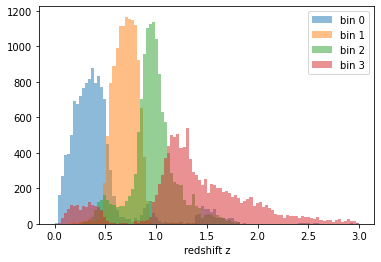

In [6]:
hist(val_z[results == 0.],100,alpha=0.5,range=[0,3], label='bin 0');
hist(val_z[results == 1.],100,alpha=0.5,range=[0,3], label='bin 1');
hist(val_z[results == 2.],100,alpha=0.5,range=[0,3], label='bin 2');
hist(val_z[results == 3.],100,alpha=0.5,range=[0,3], label='bin 3');
legend();
xlabel('redshift z');

## Computing metrics

In [7]:
# First using classic firecrown
scores = tc.compute_scores(results, val_z, metrics=['SNR_3x2', 'FOM_3x2'])

Running in serial mode (one process).

Parameter Priors
----------------
params--omega_k  ~ delta(0.0)
params--omega_c  ~ U(0.25, 0.32)
params--omega_b  ~ U(0.04, 0.05)
params--h        ~ U(0.5, 0.9)
params--n_s      ~ U(0.9, 1.02)
params--sigma8   ~ U(0.74, 0.94)
params--w0       ~ delta(-1.0)
params--wa       ~ delta(0.0)
params--bias_0   ~ delta(1.2813763809268286)
params--bias_1   ~ delta(1.4378771987902315)
params--bias_2   ~ delta(1.636016377093908)
params--bias_3   ~ delta(1.9369858590875526)


****************************
* Running sampler 1/1: fisher
* Saving output -> /tmp/tmpxify43ia/chain.txt
****************************
Calculating derivatives using 20 total models


In [8]:
scores

{'SNR_3x2': 1188.8418509306305, 'FOM_3x2': 20559.36596786123}

In [19]:
# Then using jax-cosmo
jc_scores = tc.jc_compute_scores(results, val_z, metrics=['SNR_3x2', 'FOM_3x2', 'FOM_DETF_3x2'])

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.num

In [20]:
jc_scores

{'SNR_3x2': 1180.18408203125,
 'FOM_3x2': 2018.2698974609375,
 'FOM__DETF_3x2': 46.806976318359375}

## Comparing covariances and Cls directly

In [14]:
# Compute signal and covariance with CCL
mu, C, galaxy_galaxy_tracer_bias = tc.metrics.compute_mean_covariance(results, val_z, '3x2')

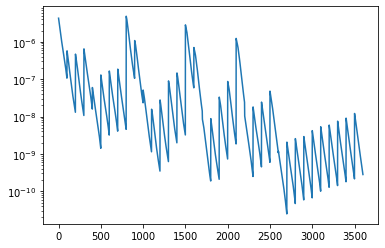

In [15]:
semilogy(mu)

In [16]:
import jax
import jax_cosmo as jc

# Recompute same thing with jax
tomo_bin = jax.nn.one_hot(results, results.max() + 1)

probes = tc.jax_metrics.get_probes(tomo_bin, val_z, what='3x2')
ell, delta_ell = tc.jax_metrics.ell_binning()

cosmo = jc.Cosmology(
    Omega_c = 0.27,
    Omega_b = 0.045,
    h = 0.67,
    n_s = 0.96,
    sigma8 = 0.8404844953840714,
    Omega_k=0.,
    w0=-1., wa=0.)

jc_mu, jc_C = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, 
                                                            ell,
                                                            probes, 
                                                            f_sky=0.25,
                                                            nonlinear_fn=jc.power.halofit)

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype <class 'jax.num

Text(0.5, 1.0, 'Signal')

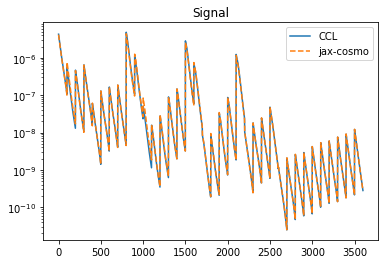

In [17]:
semilogy(mu, label='CCL')
semilogy(jc_mu, '--', label='jax-cosmo')
legend()
title('Signal')

Text(0.5, 1.0, 'Diagonal of Covariance')

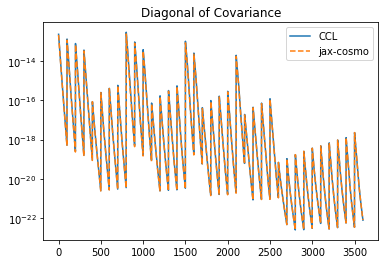

In [18]:
semilogy(diag(C), label='CCL')
semilogy(diag(jc_C),'--', label='jax-cosmo')
legend()
title('Diagonal of Covariance')